In [20]:
# =====================================================================
# Step 1: Imports and Path Setup
# ---------------------------------------------------------------------
# Loads preprocessing artifacts from Pipeline 1 and prepares output
# directories for engineered feature persistence.
# =====================================================================

import numpy as np
import pandas as pd
import joblib, json
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Directory configuration
ROOT = Path(".").resolve()
DATA_DIR = ROOT / "BODMAS"
ART_DIR = ROOT / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

# Required artifacts from Pipeline 1
required = ["Xy_splits.npz", "scaler.joblib", "splits.json", "eda.json"]
missing = [f for f in required if not (ART_DIR / f).exists()]
if missing:
    raise FileNotFoundError(f"Missing required artifact(s): {missing}")

print("Environment verified. Artifacts located at:", ART_DIR)

Environment verified. Artifacts located at: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/artifacts


In [21]:
# =====================================================================
# Step 2: Load Preprocessed Data and Split Indices
# ---------------------------------------------------------------------
# Loads full feature matrix, label vector, and chronological split
# =====================================================================

npz = np.load(ART_DIR / "Xy_splits.npz", allow_pickle=True)
X, y = npz["X"], npz["y"].astype(int)
idx_train, idx_val, idx_test = npz["idx_train"], npz["idx_val"], npz["idx_test"]

# Load previously fitted scaler
scaler = joblib.load(ART_DIR / "scaler.joblib")
X_scaled = scaler.transform(X)

print("Loaded preprocessed data:")
print(f"  Feature matrix: {X_scaled.shape}")
print(f"  Label vector:   {y.shape}")
print(f"  Splits -> Train:{len(idx_train)}, Val:{len(idx_val)}, Test:{len(idx_test)}")

Loaded preprocessed data:
  Feature matrix: (130716, 2381)
  Label vector:   (130716,)
  Splits -> Train:91501, Val:19608, Test:19607


In [24]:
# =====================================================================
# Step 3: Define Feature-Engineering Functions
# ---------------------------------------------------------------------
# Derives behavioral ratios and signature hashes from high-variance
# numeric indicators to strengthen discrimination across malware families.
# =====================================================================

import hashlib

def engineer_behavioral_features(X_block: np.ndarray) -> pd.DataFrame:
    """
    Generate derived behavioral indicators from numeric features.

    Parameters
    ----------
    X_block : np.ndarray
        Input feature matrix (samples × features).

    Returns
    -------
    pd.DataFrame
        Engineered features complementing the base representation.
    """
    df = pd.DataFrame(X_block)
    eps = 1e-6  # numerical stability

    # Example engineered ratios
    if 11 < df.shape[1]:
        df["api_success_ratio"] = (df[10] + eps) / (df[11] + eps)
    if 100 < df.shape[1] and 50 < df.shape[1]:
        df["network_file_ratio"] = (df[100] + eps) / (df[50] + eps)

    # Behavior hash: compressed binary fingerprint of top-variance features
    topk = np.argsort(-np.var(X_block, axis=0))[:64]
    signature = (X_block[:, topk] > X_block[:, topk].mean(axis=0)).astype(int)
    df["behavior_hash"] = (signature * (1 << np.arange(signature.shape[1]))).sum(axis=1) % 1024

    return df
print("Done...")

Done...


In [25]:
# =====================================================================
# Step 4: Apply Feature-Engineering Functions per Dataset Split
# ---------------------------------------------------------------------
# Builds enhanced feature matrices [original + engineered] for each
# subset to enable later comparison between baseline and enriched models.
# =====================================================================

def build_enhanced_features(X_source, indices):
    base = pd.DataFrame(X_source[indices])
    base.columns = [f"f_{i}" for i in range(base.shape[1])]
    engineered = engineer_behavioral_features(X_source[indices])
    enhanced = pd.concat([base, engineered], axis=1)
    return enhanced

X_train_enh = build_enhanced_features(X_scaled, idx_train)
X_val_enh   = build_enhanced_features(X_scaled, idx_val)
X_test_enh  = build_enhanced_features(X_scaled, idx_test)

print("Enhanced feature sets generated:")
print(f"  Train: {X_train_enh.shape}")
print(f"  Val:   {X_val_enh.shape}")
print(f"  Test:  {X_test_enh.shape}")

Enhanced feature sets generated:
  Train: (91501, 4765)
  Val:   (19608, 4765)
  Test:  (19607, 4765)


In [26]:
# =====================================================================
# Step 5: Inspect engineered feature distributions
# ---------------------------------------------------------------------
# Objective:
#   Perform a quick statistical overview of new features to ensure
#   numeric validity and absence of extreme outliers.
# =====================================================================

feature_subset = ["api_success_ratio", "network_file_ratio", "behavior_hash"]

summary_stats = X_train_enh[feature_subset].describe().T
print("Summary statistics for engineered features:\n")
print(summary_stats)

Summary statistics for engineered features:

                      count        mean         std           min        25%  \
api_success_ratio   91501.0   -0.611245  209.563416 -37999.726562  -0.145231   
network_file_ratio  91501.0    0.710723   52.598885  -5595.964844   0.076601   
behavior_hash       91501.0  147.978055  110.515567     32.000000  96.000000   

                          50%         75%           max  
api_success_ratio    0.442598    0.790323  13944.598633  
network_file_ratio   1.695298    2.227325   6649.985352  
behavior_hash       96.000000  100.000000    984.000000  


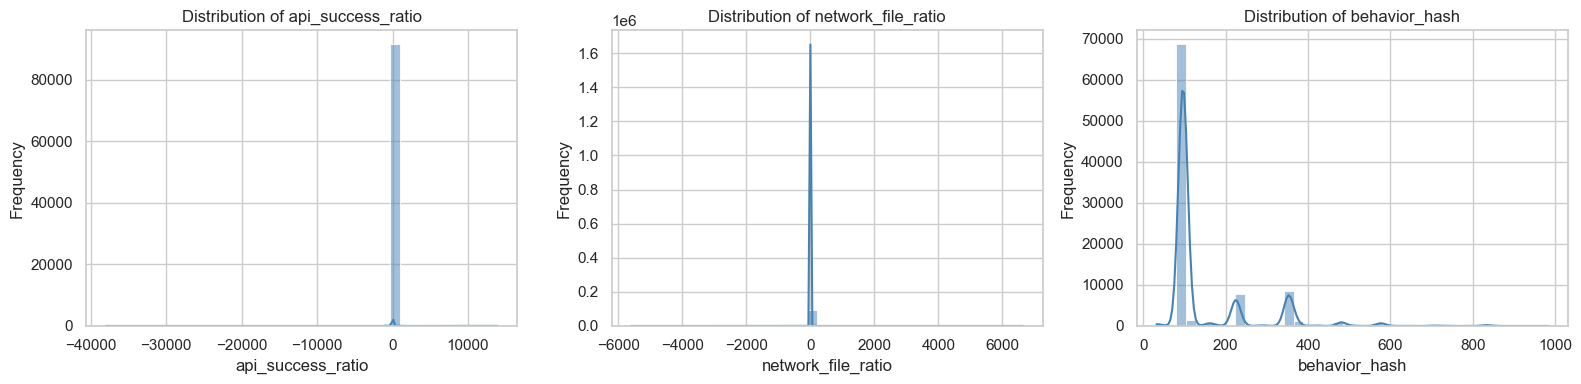

In [28]:
# =====================================================================
# Step 6: Visualize engineered feature distributions
# ---------------------------------------------------------------------
# Objectives:
#   1. Plot histograms to verify scale and variation of engineered features.
#   2. Check that no feature dominates numerically.
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, col in zip(axes, feature_subset):
    sns.histplot(X_train_enh[col], bins=40, color="steelblue", ax=ax, kde=True)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [29]:
# =====================================================================
# Step 7: Save Enhanced Feature Matrices
# ---------------------------------------------------------------------
# Persists engineered train/val/test sets for model training and
# comparative evaluation against baseline representations.
# =====================================================================

import joblib

joblib.dump(X_train_enh, ART_DIR / "X_train_enh.pkl")
joblib.dump(X_val_enh,   ART_DIR / "X_val_enh.pkl")
joblib.dump(X_test_enh,  ART_DIR / "X_test_enh.pkl")

print("Enhanced feature matrices saved in artifacts/:")
for f in ART_DIR.glob("X_*_enh.pkl"):
    print(" -", f.name)

Enhanced feature matrices saved in artifacts/:
 - X_train_enh.pkl
 - X_test_enh.pkl
 - X_val_enh.pkl
